# Project 4: Predict West Nile Virus
### Section 2: Trap & Spray Data Cleaning & EDA

## Problem Statement

1. As an employee of Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE), we are tasked to better understand the mosquito population and advise on appropriate interventions which are beneficial and cost-effective for the city.


2. Through this project, we hope to:
- Identify features which are most important to predict presence of West Nile Virus (which can be done by ranking the coefficients of each feature in a logistic regression model)
- Predict the probability of West Nile Virus by location to provide decision makers an effective plan to deploy pesticides throughout the city, which consequently can help to reduce cost.

## Import Libraries

In [1]:
#!pip install shapely
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import geometry
from shapely.geometry import Point, Polygon
import geopandas as gpd
from datetime import timedelta
import math
import datetime as dt

In [2]:
# Set chart style
plt.style.use('fivethirtyeight')

## Load Data

In [3]:
# Load datasets
traintest_data = pd.read_csv('../data/data_traintest.csv', index_col='Unnamed: 0')
spray = pd.read_csv('../data/data_spray.csv', index_col='Unnamed: 0')

In [4]:
# Check columns and null values
traintest_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126799 entries, 0 to 126798
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   dataset                 126799 non-null  object 
 1   date                    126799 non-null  object 
 2   address                 126799 non-null  object 
 3   species                 126799 non-null  object 
 4   block                   126799 non-null  int64  
 5   street                  126799 non-null  object 
 6   trap                    126799 non-null  object 
 7   addressnumberandstreet  126799 non-null  object 
 8   latitude                126799 non-null  float64
 9   longitude               126799 non-null  float64
 10  addressaccuracy         126799 non-null  int64  
 11  nummosquitos            10506 non-null   float64
 12  wnvpresent              10506 non-null   float64
 13  year                    126799 non-null  int64  
 14  month               

In [5]:
# Check columns and null values
spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14835 entries, 0 to 14834
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       14835 non-null  object 
 1   time       14251 non-null  object 
 2   latitude   14835 non-null  float64
 3   longitude  14835 non-null  float64
 4   year       14835 non-null  int64  
 5   month      14835 non-null  int64  
 6   week       14835 non-null  int64  
 7   dayofweek  14835 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 1.0+ MB


In [6]:
# Convert date column to datetime type 
traintest_data['date'] = pd.to_datetime(traintest_data['date'])
spray['date'] = pd.to_datetime(spray['date'])

In [7]:
# Split train test data as mosquito count is only in train data
train = traintest_data[traintest_data['dataset']=='train'].copy()
test = traintest_data[traintest_data['dataset']=='test'].copy()

### Spray Data

In [8]:
# There are 9 NaN values for timing of spray. 
# We will drop this column as we would not be using this column.
spray.drop(columns='time', inplace=True)

### Train Test Data

#### Duplicate rows

According to the Data Description on Kaggle: "These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50."

We will first check for rows that are duplicates that are not 50

In [9]:
train.shape

(10506, 17)

In [10]:
# There are 106 rows that are duplicates that are not nummosquito = 50
train[((train['nummosquitos']!=50) & train.duplicated())].head()

,dataset,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,month,week,dayofweek
99,train,2007-06-26,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1.0,0.0,2007,6,26,1
512,train,2007-07-18,"3300 West Randolph Street, Chicago, IL 60612, USA",CULEX RESTUANS,33,E RANDOLPH ST,T044,"3300 E RANDOLPH ST, Chicago, IL",41.883284,-87.705085,8,1.0,0.0,2007,7,29,2
819,train,2007-08-01,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1.0,0.0,2007,8,31,2
854,train,2007-08-01,"7500 North Oakley Avenue, Chicago, IL 60645, USA",CULEX PIPIENS/RESTUANS,75,N OAKLEY AVE,T148,"7500 N OAKLEY AVE, Chicago, IL",42.017430,-87.687769,8,2.0,0.0,2007,8,31,2
857,train,2007-08-01,"7500 North Oakley Avenue, Chicago, IL 60645, USA",CULEX PIPIENS,75,N OAKLEY AVE,T148,"7500 N OAKLEY AVE, Chicago, IL",42.017430,-87.687769,8,1.0,0.0,2007,8,31,2


In [11]:
# Drop rows that are duplicates that are not nummosquito = 50
train = train[~((train['nummosquitos']!=50) & train.duplicated())]

In [12]:
train.columns

Index(['dataset', 'date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent', 'year', 'month', 'week', 'dayofweek'],
      dtype='object')

In [13]:
# Do a list of all columns except nummosquito
allcols_except_nummosquito = ['dataset', 'date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy', 'wnvpresent', 'year', 'month', 'week', 'dayofweek']

In [14]:
# Check sum of nummosquitos
train['nummosquitos'].sum()

134321.0

In [15]:
# Check: number of rows
train.shape

(10400, 17)

In [16]:
# Sum nummosquitos for unique rows
train = train.groupby(allcols_except_nummosquito).sum().reset_index(inplace=False)

In [17]:
# Check: train_processing was summed correctly as we have the correct sum of nummosquito
train['nummosquitos'].sum()

134321.0

In [18]:
# Check: train_processing was summed correctly as we have the correct rows
train.shape

(8610, 17)

In [19]:
test.shape

(116293, 17)

In [20]:
test.duplicated().sum()

1533

In [21]:
test.drop_duplicates(inplace=True)

We have dropped 106 duplicate rows in Train and 1533 rows in Test, and combined 1,790 rows in Train.

In [22]:
traintest = pd.concat([train,test], axis=0)

#### Trap, Address and Location
Check for consistency across Trap, Address and Location columns

In [23]:
# Description of the number of times each trap appears in the dataset
traintest.loc[traintest['dataset'] == 'train', 'trap'].value_counts().describe()

count    136.000000
mean      63.308824
std       43.907734
min        2.000000
25%       22.000000
50%       61.000000
75%       98.500000
max      182.000000
Name: trap, dtype: float64

In [24]:
# Description of the number of times each trap appears in the dataset
traintest.loc[traintest['dataset'] == 'test', 'trap'].value_counts().describe()

count     149.000000
mean      770.201342
std        87.753261
min       760.000000
25%       760.000000
50%       760.000000
75%       760.000000
max      1520.000000
Name: trap, dtype: float64

Most traps appear 760 times in the test dataset, but there are two that appear twice that number, 1520 times.

We would check for non-unique addresses to confirm if these are duplicates or error

In [25]:
# Description of the number of times each trap appears in the dataset
traintest.loc[traintest['dataset'] == 'test', 'trap'].value_counts().loc[lambda x: x>760]

T009    1520
T035    1520
Name: trap, dtype: int64

In [26]:
# Count unique rows of trap name, address, and location
unique_address = pd.DataFrame(traintest[['trap','block','address','street',
                       'addressnumberandstreet','latitude',
                       'longitude','addressaccuracy']].value_counts())

In [27]:
# Select traps that have more than one address location combination
repeat_traps = unique_address.value_counts('trap').loc[lambda x: x>1]

In [28]:
# View traps that have more than one address location combination
# Add dataset column to unique_address
unique_address = pd.DataFrame(traintest[['trap','dataset', 'block','address','street',
                       'addressnumberandstreet','latitude',
                       'longitude','addressaccuracy']].value_counts())
unique_address.loc[repeat_traps.index.tolist()]

0
trap dataset block address                                          street         addressnumberandstreet           latitude  longitude  addressaccuracy     
T009 test    91    9100 West Higgins Road, Rosemont, IL 60018, USA   W HIGGINS RD  9100  W HIGGINS RD, Chicago, IL  41.992478 -87.862995 8                760
                   9100 West Higgins Avenue, Chicago, IL 60656, USA  W HIGGINS AVE 9100  W HIGGINS AVE, Chicago, IL 41.981964 -87.812827 8                760
     train   91    9100 West Higgins Road, Rosemont, IL 60018, USA   W HIGGINS RD  9100  W HIGGINS RD, Chicago, IL  41.992478 -87.862995 8                 70
                   9100 West Higgins Avenue, Chicago, IL 60656, USA  W HIGGINS AVE 9100  W HIGGINS AVE, Chicago, IL 41.981964 -87.812827 8                 27
T035 test    30    3000 South Hoyne Avenue, Chicago, IL 60608, USA   S HOYNE AVE   3000  S HOYNE AVE, Chicago, IL   41.836644 -87.677737 8                760
             51    5100 West 72nd Street, Chicago, IL 60638, USA     W 72ND ST     5100  W 72ND ST, Chicago, IL     41.763733 -87.742302 8                760
     train   51    5100 West 72nd Street, Chicago, IL 60638, USA     W 72ND ST     5100  W 72ND ST, Chicago, IL     41.763733 -87.742302 8                 45
             30    3000 South Hoyne Avenue, Chicago, IL 60608, USA   S HOYNE AVE   3000  S HOYNE AVE, Chicago, IL   41.836644 -87.677737 8                 27

The same traps that have 1520 rows in the test data appears again in our non-unique address analysis, having different address and location coordinates. Hence its probable that these are seperate traps, probably satelite traps.

In [29]:
# Select dates that have two different coordinates
# Step 1: Select traps of interest and get list of unique rows
duplicate_check1 = traintest.loc[traintest['trap'].isin(['T009','T035']),
                                 ['date','trap','latitude','longitude']].value_counts()
display(duplicate_check1)

date        trap  latitude   longitude 
2010-09-13  T009  41.981964  -87.812827    8
2012-06-08  T035  41.836644  -87.677737    8
2012-07-19  T035  41.836644  -87.677737    8
                  41.763733  -87.742302    8
            T009  41.992478  -87.862995    8
                                          ..
2009-06-12  T009  41.992478  -87.862995    1
2013-09-06  T035  41.763733  -87.742302    1
2013-09-19  T009  41.992478  -87.862995    1
2013-09-26  T009  41.992478  -87.862995    1
2007-06-05  T009  41.981964  -87.812827    1
Length: 476, dtype: int64

In [30]:
# Select dates that have two different coordinates
# Step 2: Select dates where traps have more than one latitude and longitude
duplicate_check2 = duplicate_check1.reset_index().drop(columns=0)[['date','trap']] \
                        .value_counts().loc[lambda x: x>1]
duplicate_check2

date        trap
2010-09-16  T035    2
2010-09-23  T009    2
2010-09-24  T009    2
            T035    2
2010-10-01  T009    2
                   ..
2010-06-25  T035    2
2010-06-28  T035    2
2010-06-02  T009    2
2010-07-01  T009    2
            T035    2
Length: 190, dtype: int64

Furthermore these traps had readings in both locations on the same day. We propose to rename one of the trap location by adding a letter to the existing trap label.

In [31]:
# Check if T009 already exists
traintest[traintest['trap']=='T009A']

,dataset,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,wnvpresent,year,month,week,dayofweek,nummosquitos


In [32]:
# Check if T305A already exists
traintest[traintest['trap']=='T035A']

,dataset,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,wnvpresent,year,month,week,dayofweek,nummosquitos


In [33]:
# Rename trap rows with different address
traintest.loc[(traintest['latitude']==41.981964)&(traintest['longitude']==-87.812827),'trap'] = 'T009A'

In [34]:
# Rename trap rows with different address
traintest.loc[(traintest['latitude']==41.763733)&(traintest['longitude']==-87.742302),'trap'] = 'T035A'

In [35]:
# Drop address related columns
traintest.drop(columns=['address', 'street','addressnumberandstreet','addressaccuracy','block'], 
               inplace=True, errors='ignore')

#### Mosquito categories

We observe that there are 3 similar categories of mosquitoes, `CULEX PIPIENS/RESTUANS`, `CULEX PIPIENS`, and `CULEX RESTUANS`. From its name, it suggests that the second and third may be subsets of the first.

We observe from the sum of number of mosquitos by category that the sum of `CULEX PIPIENS/RESTUANS`, `CULEX PIPIENS`, and `CULEX RESTUANS`

In [36]:
# Split train test data as mosquito count is only in train data
train = traintest[traintest['dataset']=='train'].copy()
test = traintest[traintest['dataset']=='test'].copy()

In [37]:
# Inspect count of species
train.groupby(['species'])['nummosquitos'].sum()

species
CULEX ERRATICUS               7.0
CULEX PIPIENS             44488.0
CULEX PIPIENS/RESTUANS    65841.0
CULEX RESTUANS            23326.0
CULEX SALINARIUS            144.0
CULEX TARSALIS                7.0
CULEX TERRITANS             508.0
Name: nummosquitos, dtype: float64

In [38]:
# Inspect count of species by wnvpresent
train.groupby(['species','wnvpresent'])['nummosquitos'].sum()

species                 wnvpresent
CULEX ERRATICUS         0.0               7.0
CULEX PIPIENS           0.0           37759.0
                        1.0            6729.0
CULEX PIPIENS/RESTUANS  0.0           58739.0
                        1.0            7102.0
CULEX RESTUANS          0.0           22659.0
                        1.0             667.0
CULEX SALINARIUS        0.0             144.0
CULEX TARSALIS          0.0               7.0
CULEX TERRITANS         0.0             508.0
Name: nummosquitos, dtype: float64

In [39]:
# Drop rows for categories with total few number of mosquitos
train = train[train['species']
                 .isin(['CULEX PIPIENS','CULEX PIPIENS/RESTUANS','CULEX RESTUANS'])]
test = test[test['species']
                 .isin(['CULEX PIPIENS','CULEX PIPIENS/RESTUANS','CULEX RESTUANS'])]

In [40]:
# Select columns to remain along the index in pivot table
select_cols = ['dataset', 'date', 'trap', 'latitude', 
                              'longitude','wnvpresent', 'year', 'month', 'week', 'dayofweek']

In [41]:
# Pivot table 
train_pivot = train.pivot_table(index = select_cols, 
                                           columns='species', 
                                           values='nummosquitos',
                                           fill_value=0).reset_index()

In [42]:
# Create a column to sum the mosquito counts of 'CULEX PIPIENS' and'CULEX RESTUANS'
train_pivot['sum_species'] = train_pivot['CULEX PIPIENS'] + train_pivot['CULEX RESTUANS']

In [43]:
# Create a column to find the difference between the mosquito counts of 
# 'CULEX PIPIENS/RESTUANS' and the sum of 'CULEX PIPIENS' and'CULEX RESTUANS'
train_pivot['compare'] = train_pivot['sum_species'] - train_pivot['CULEX PIPIENS/RESTUANS']

In [44]:
# Count of zero differences
train_pivot[(train_pivot['CULEX PIPIENS/RESTUANS']!= 0)]['compare'].value_counts()

-1      555
-2      361
 0      293
-3      273
 1      193
       ... 
 69       1
-797      1
-62       1
-105      1
 33       1
Name: compare, Length: 238, dtype: int64

In [45]:
# distribution of differences between columns 
# between categories of 'CULEX PIPIENS/RESTUANS' 
# and sum of 'CULEX PIPIENS' and'CULEX RESTUANS'
# where virus is NOT present
train_pivot[(train_pivot['CULEX PIPIENS/RESTUANS']!= 0) & (train_pivot['wnvpresent']==0)]['compare'].describe()

count    3674.000000
mean       -1.686445
std        81.248066
min     -1421.000000
25%        -6.000000
50%        -2.000000
75%         0.000000
max      1990.000000
Name: compare, dtype: float64

In [46]:
# distribution of differences between columns 
# between categories of 'CULEX PIPIENS/RESTUANS' 
# and sum of 'CULEX PIPIENS' and'CULEX RESTUANS'
# where virus is present
train_pivot[(train_pivot['CULEX PIPIENS/RESTUANS']!= 0) & (train_pivot['wnvpresent']==1)]['compare'].describe()

count    225.000000
mean     -16.906667
std       53.431241
min     -436.000000
25%      -35.000000
50%      -16.000000
75%       -4.000000
max      438.000000
Name: compare, dtype: float64

<AxesSubplot:>

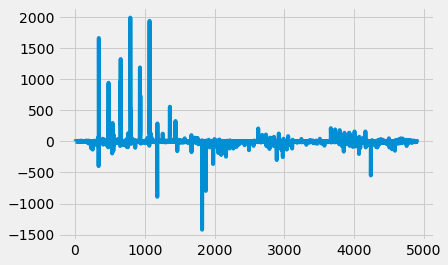

In [47]:
# Plot the difference between categories of 'CULEX PIPIENS/RESTUANS' 
# and sum of 'CULEX PIPIENS' and'CULEX RESTUANS' 
# where virus is NOT present
train_pivot[(train_pivot['CULEX PIPIENS/RESTUANS']!= 0) & (train_pivot['wnvpresent']==0)]['compare'].plot()

<AxesSubplot:>

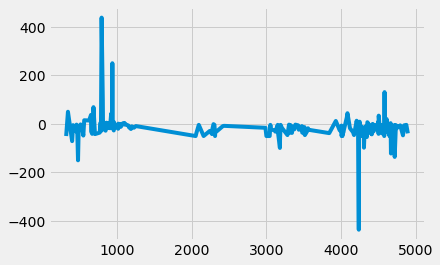

In [48]:
# Plot the difference between categories of 'CULEX PIPIENS/RESTUANS' 
# and sum of 'CULEX PIPIENS' and'CULEX RESTUANS' 
# where virus is present
train_pivot[(train_pivot['CULEX PIPIENS/RESTUANS']!= 0) & (train_pivot['wnvpresent']==1)]['compare'].plot()

Text(0.5, 1.0, 'Correlation of Species count for observations where WNV is present')

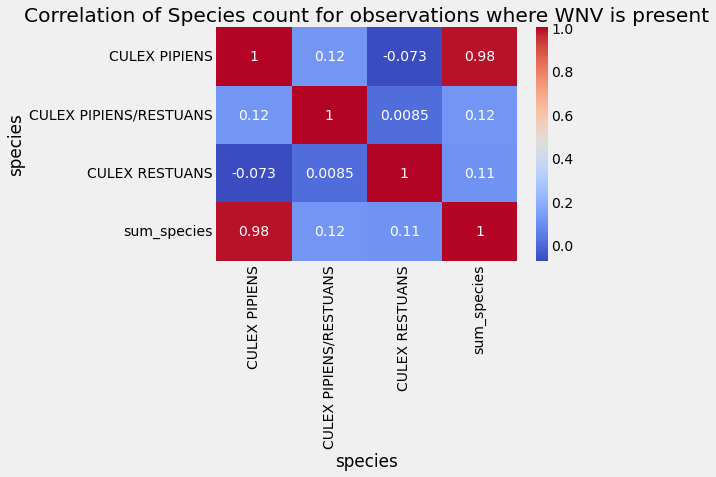

In [49]:
# Plot the correlation bewteen the count of 3 species categories 
# and sum of 'CULEX PIPIENS' and'CULEX RESTUANS' 
# where WNV is present
sns.heatmap(train_pivot[train_pivot['wnvpresent']==1][['CULEX PIPIENS','CULEX PIPIENS/RESTUANS',
                                                       'CULEX RESTUANS','sum_species']].corr(),
            cmap='coolwarm',
            annot=True            
           )
plt.title('Correlation of Species count for observations where WNV is present') 

In [50]:
# Create boolean columns to indicate if each species is present in the observation or not
train_pivot['cp_bool'] = train_pivot['CULEX PIPIENS'].astype(bool)
train_pivot['cpr_bool'] = train_pivot['CULEX PIPIENS/RESTUANS'].astype(bool)
train_pivot['cr_bool'] = train_pivot['CULEX RESTUANS'].astype(bool)
train_pivot['sum_bool'] = train_pivot['sum_species'].astype(bool)

<AxesSubplot:title={'center':'Correlation of Species existence (Boolean) for observations where WNV is present'}, xlabel='species', ylabel='species'>

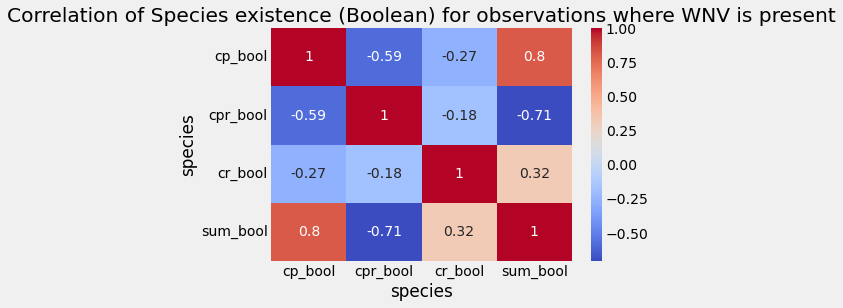

In [51]:
# Plot the correlation bewteen the existence of 3 species categories 
# and sum of 'CULEX PIPIENS' and'CULEX RESTUANS' 
# where WNV is present
plt.title('Correlation of Species existence (Boolean) for observations where WNV is present') 
sns.heatmap(train_pivot[train_pivot['wnvpresent']==1][['cp_bool','cpr_bool','cr_bool','sum_bool']].corr(),
            cmap='coolwarm',
            annot=True            
           )

Text(0.5, 1.0, 'Correlation of Species count for observations where WNV is not present')

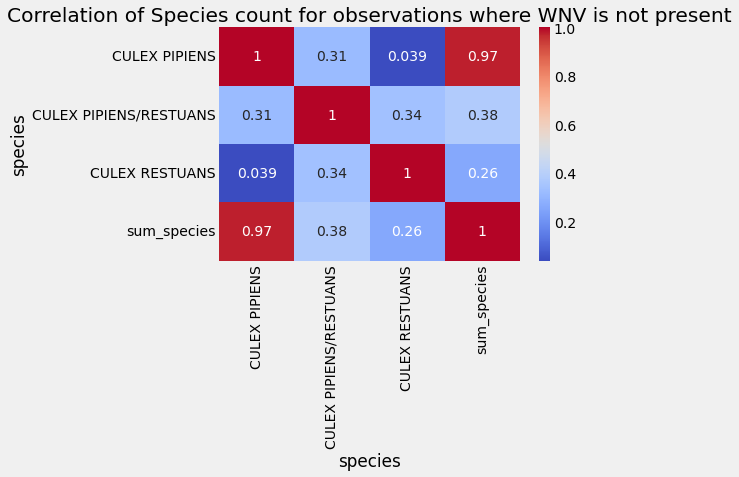

In [52]:
# Plot the correlation bewteen the count of 3 species categories 
# and sum of 'CULEX PIPIENS' and'CULEX RESTUANS' 
# where WNV is NOT present
sns.heatmap(train_pivot[train_pivot['wnvpresent']==0][['CULEX PIPIENS','CULEX PIPIENS/RESTUANS',
                                                       'CULEX RESTUANS','sum_species']].corr(),
            cmap='coolwarm',
            annot=True            
           )
plt.title('Correlation of Species count for observations where WNV is not present') 

<AxesSubplot:title={'center':'Correlation of Species existence (Boolean) for observations where WNV is not present'}, xlabel='species', ylabel='species'>

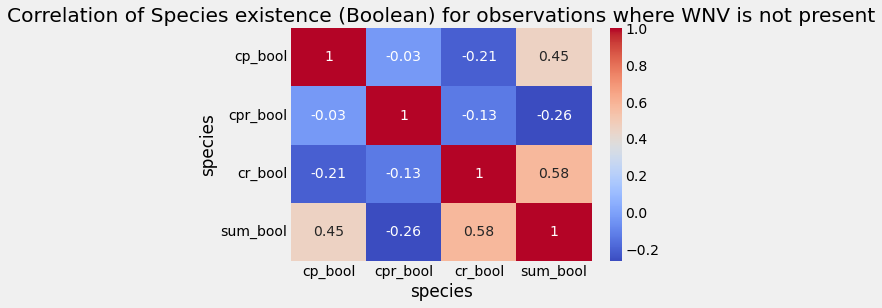

In [53]:
# Plot the correlation bewteen the existence of 3 species categories 
# and sum of 'CULEX PIPIENS' and'CULEX RESTUANS' 
# where WNV is NOT present
plt.title('Correlation of Species existence (Boolean) for observations where WNV is not present') 
sns.heatmap(train_pivot[train_pivot['wnvpresent']==0][['cp_bool','cpr_bool','cr_bool','sum_bool']].corr(),
            cmap='coolwarm',
            annot=True            
           )

There doesnt seem to be systematic duplication of data. Only 293 rows out of 3899 or 8% had zero differences and non-zero mosquito counts. Also, there is low correlation between the rows for both numerical values and count (existence of mosquitoes) are low.

Hence we propose to leave the data as it is.

In [54]:
traintest = pd.concat([train,test], axis=0)

### Export CSV

In [55]:
traintest.to_csv('../data/processed_traintest.csv')

In [56]:
spray.to_csv('../data/processed_spray.csv')

#### Joining TrainTest and Spray dataframes

Note: the csv is exported before this as there is code in section 3 that joins the traintest data and spray dataframe

In [57]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14835 entries, 0 to 14834
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       14835 non-null  datetime64[ns]
 1   latitude   14835 non-null  float64       
 2   longitude  14835 non-null  float64       
 3   year       14835 non-null  int64         
 4   month      14835 non-null  int64         
 5   week       14835 non-null  int64         
 6   dayofweek  14835 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 927.2 KB


In [58]:
spray['date'].value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: date, dtype: int64

In [59]:
# create list of dates
spray_dates = spray['date'].value_counts().index

In [60]:
# create function to return 1 if trap received spray within 1.1km (0.01 degree of latitude) within the past 7 day
def near_spray(trap_lat, trap_long, date, distance=0.01, days=7):
    
    """ Input latitude and longitude of trap and date of interest. Return 1 if trap received spray 
    within 1.1km (0.01 degree of latitude) within the past 7 day
    date = date that trap was checked
    
    """
    
    trap_loc = geometry.Point(trap_lat, trap_long)

    # create your circle buffer from trap_loc
    circle_buffer = trap_loc.buffer(distance)

    for lat, long in zip(list(spray.loc[(spray['date'] <= date) & 
                                        (spray['date'] >= (date - timedelta(days=days))),'latitude']), 
                         list(spray.loc[(spray['date'] <= date) & 
                                        (spray['date'] >= (date - timedelta(days=days))),'longitude'])):
        spray_loc = geometry.Point(lat, long)

        # and you can then check if the other point lies within
        if spray_loc.within(circle_buffer):
            return 1

In [61]:
# create a column is_spray - 1 if trap received spray within 1.1km (0.01 degree of latitude) within the past 7 day
traintest['is_spray'] = traintest.apply(
    lambda row: near_spray(row['latitude'], row['longitude'], row['date'], distance=0.01, days=7),
    axis = 1
)

In [62]:
traintest['latitude'][0]

41.867108

In [63]:
# number of traps sprayed within 1.1km (0.01 degree of latitude) within the past 7 days
traintest.loc[traintest['is_spray']==1,['date', 'trap', 'is_spray']].groupby('date').count()

,trap,is_spray
date,,
2011-09-12,2,2
2013-07-19,12,12
2013-07-25,1,1
2013-08-01,3,3
2013-08-08,3,3
2013-08-15,13,13
2013-08-22,22,22
2013-08-29,14,14
2013-09-06,2,2


In [64]:
traintest['is_spray'].fillna(0, inplace=True)

### Export CSV

In [65]:
traintest.shape

(51339, 13)

### Translate Location Data for Trap location in Train & Test and Spray Locations

We would use Shapely and Geopandas packages to process and visualize location data

In [66]:
# Define Coordinate Reference System type (according to the map boundary files)
crs = {'init':'epsg:4326'}

In [67]:
# Trap Locations
# Create column of Shapely Point objects of the location of each trap
geometry = [Point(xy) for xy in zip(traintest['longitude'], traintest['latitude'])]
# Transform traintest into a GeoDataFrame
geo_traintest = gpd.GeoDataFrame(traintest,
                         crs=crs,
                          geometry=geometry
                         )

In [68]:
# Spray Locations
# Create column of Shapely Point objects of the location of each spray
spray_location = [Point(xy) for xy in zip(spray['longitude'], spray['latitude'])]
# Transform traintest into a GeoDataFrame
geo_spray = gpd.GeoDataFrame(spray,
                             crs=crs,
                             geometry=spray_location
                            )

In [69]:
# Weather Stations
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
stations = {'Latitude':[41.995,41.786], 'Longitude':[-87.933,-87.752]}

In [70]:
# Create column of Shapely Point objects of the location of each weather station
station_location = [Point(xy) for xy in zip(stations['Longitude'], stations['Latitude'])]
# Transform to GeoDataFrame
geo_stations = gpd.GeoDataFrame(stations,
                         crs=crs,
                          geometry=station_location
                         )

In [71]:
# import community and precinct map boundary files
community_map = gpd.read_file('../data/Boundaries - Community Areas (current)/geo_export_696264d7-9f06-473f-a0d2-238466734f0f.shp')
precinct_map = gpd.read_file('../data/Precincts (current)/geo_export_c00eb2b5-21d4-4f5f-be2b-399758f8fb18.shp')

### EDA

In [72]:
# Create masks for categorical and numerical features
category_columns = [key for key, val in geo_traintest.iteritems() 
                    if geo_traintest.dtypes[key] == 'object']
numerical_columns = [key for key, val in geo_traintest.iteritems() 
                     if (geo_traintest.dtypes[key] == 'int64') or 
                     (geo_traintest.dtypes[key] == 'float64') or
                     (geo_traintest.dtypes[key] == 'datetime64[ns]')
                    ]
print(len(category_columns))
print(len(numerical_columns))

3
10


In [74]:
geo_traintest.to_csv('../data/geo_traintest.csv')

#### Histograms

Text(0.5, 1.1, 'Histograms of Numeric Features')

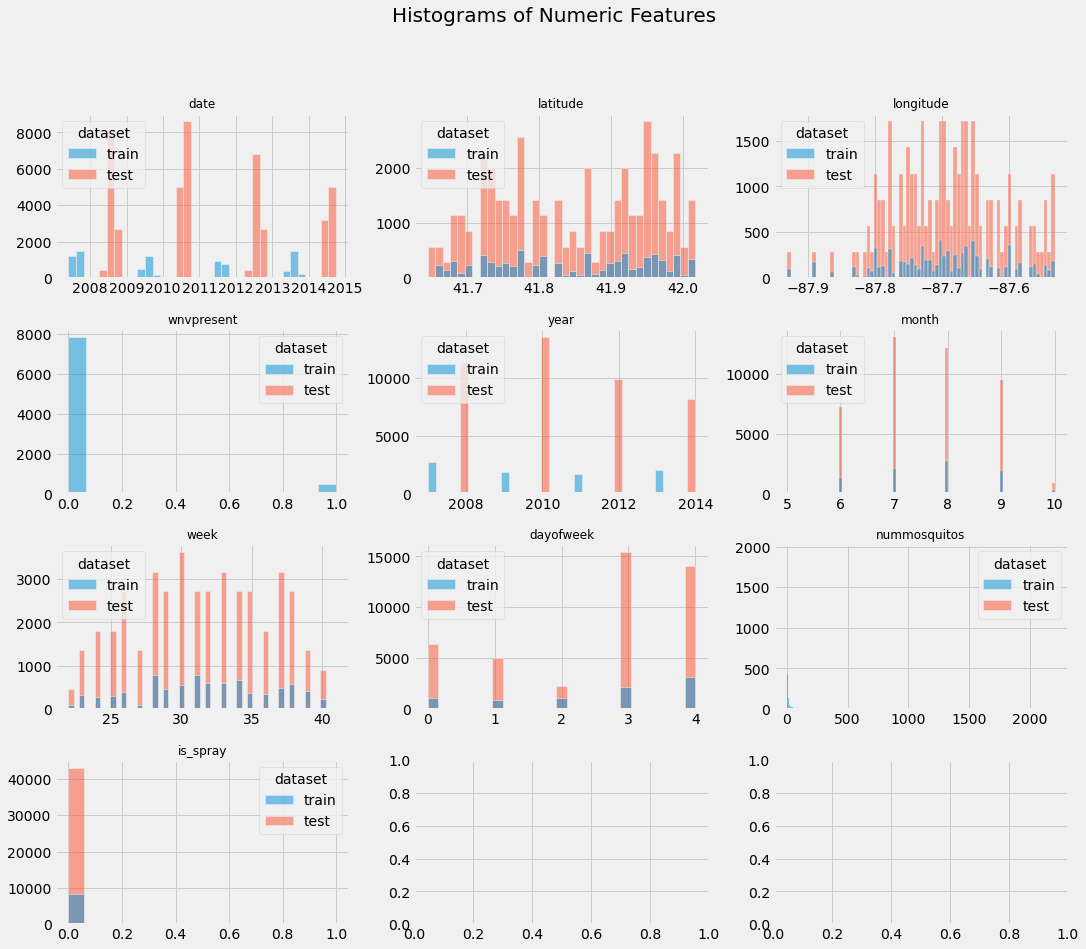

In [73]:
# Plot histograms of numeric features
cols = 3
rows = math.ceil(len(numerical_columns)/cols)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows*3))
plt.tight_layout(h_pad=2, w_pad=2)

ax = ax.ravel()

for i, column in enumerate(numerical_columns):
    g = sns.histplot(data = geo_traintest, x=column, hue='dataset', ax=ax[i])
    ax[i].set_title(column,fontsize=12)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
fig.suptitle('Histograms of Numeric Features', 
             fontsize=20,y=1.1)  

Initial observations:
- Test data size is much larger than train data. 
- Date range is not continuous, train and test data fall under alternate years (i.e. train dataset only has data in the odd years e.g. 2007, 2009 while test dataset only has data in the even years e.g. 2008, 2010)

#### Date and Trap data

[Text(0.5, 1.0, 'Scatterplot of Traps(y-axis) against Time(x-axis) - Train & Test')]

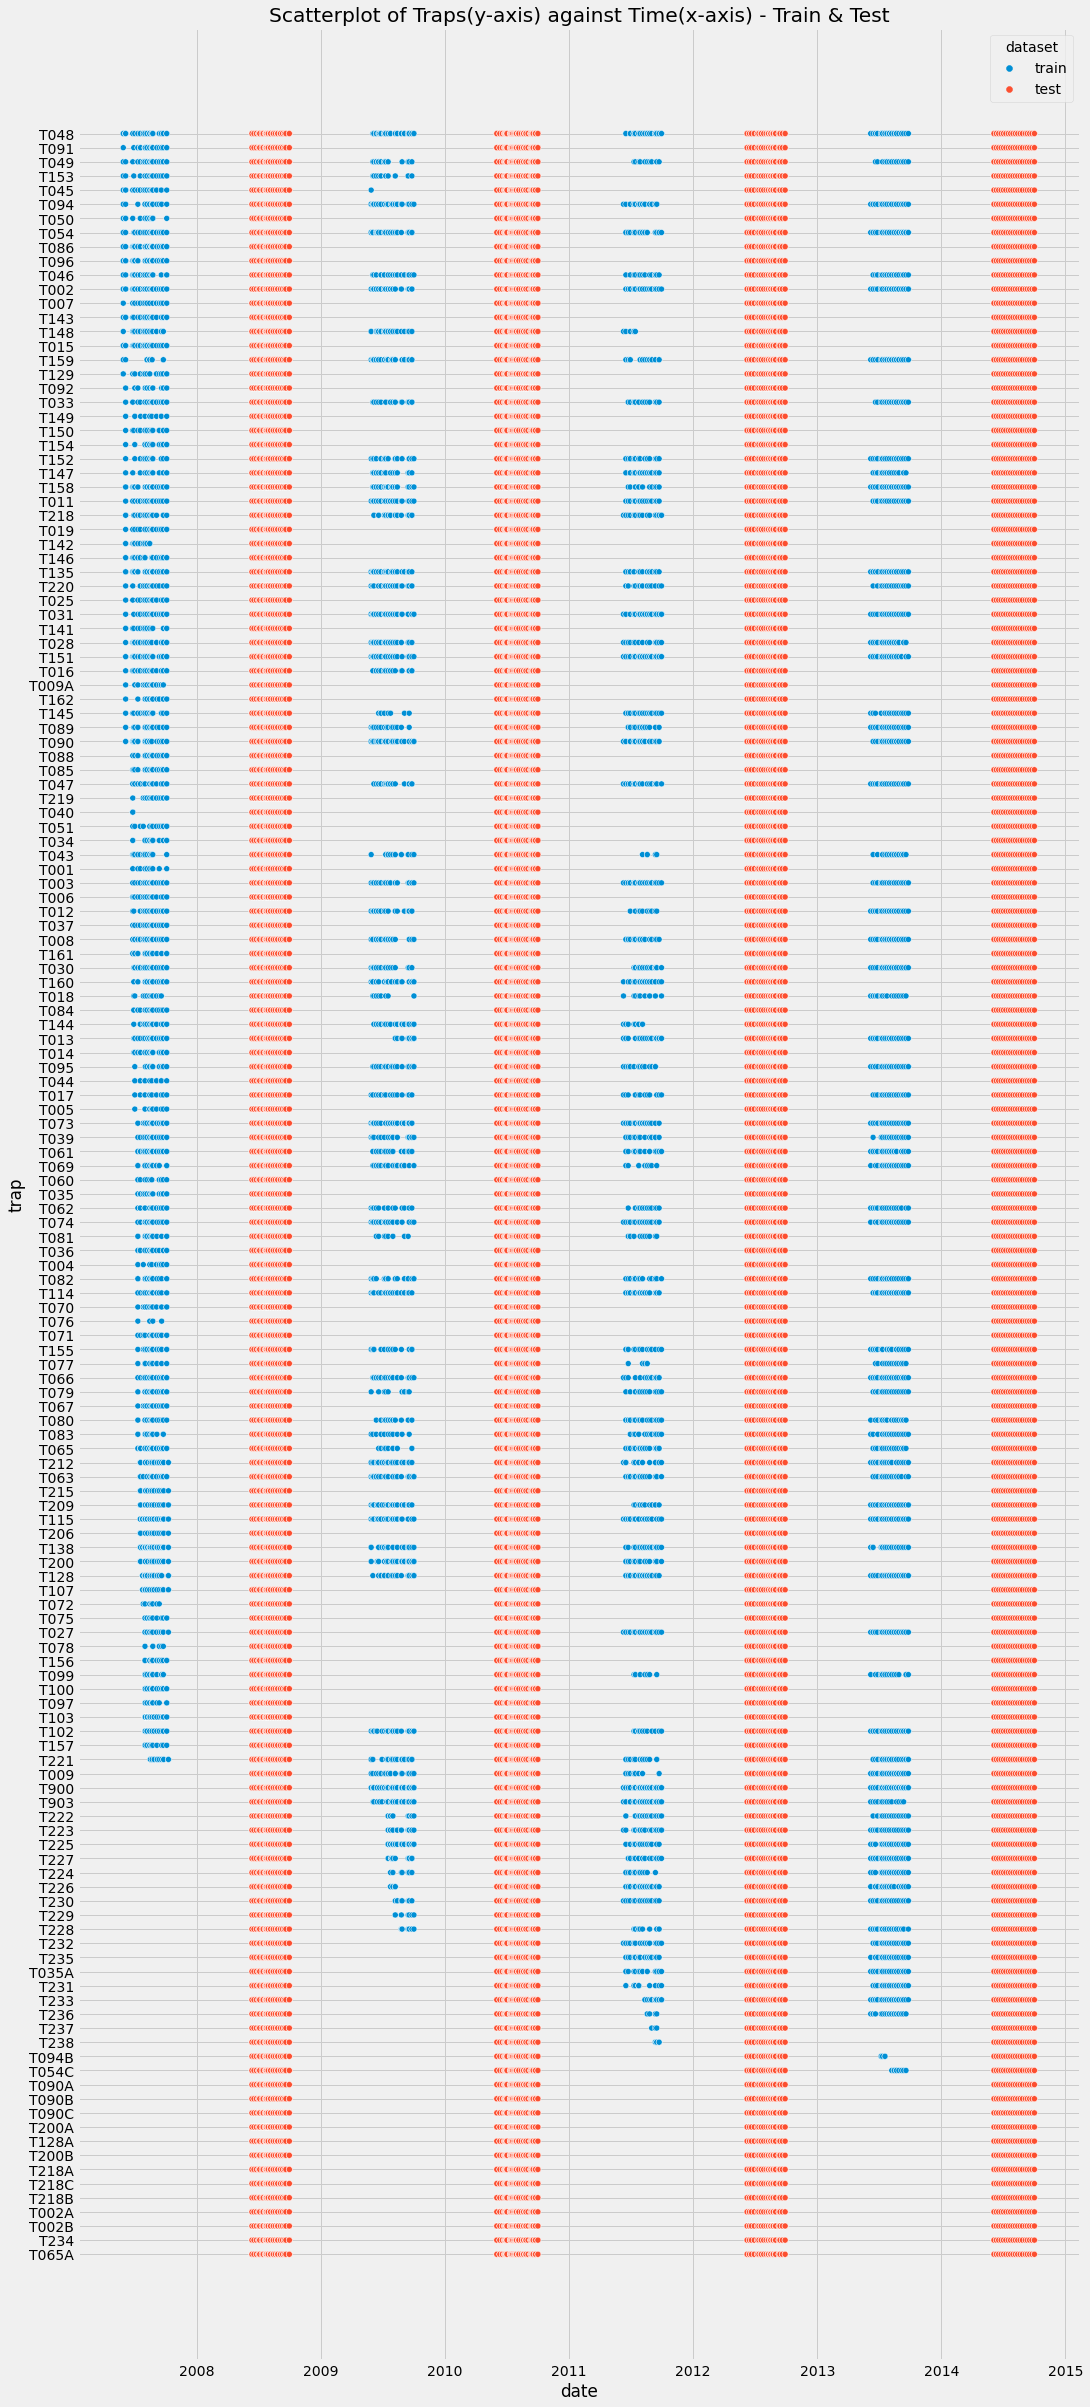

In [74]:
fig,ax = plt.subplots(figsize=(16,40))
sns.scatterplot(data=geo_traintest, x='date', y='trap', hue='dataset',) \
                .set(title= 'Scatterplot of Traps(y-axis) against Time(x-axis) - Train & Test')

- There are 13 traps which are present in the test dataset which are not present in the train dataset
- Trap data collection is inconsistent across the years

[Text(0.5, 1.0, 'Counts of WNV presence by year')]

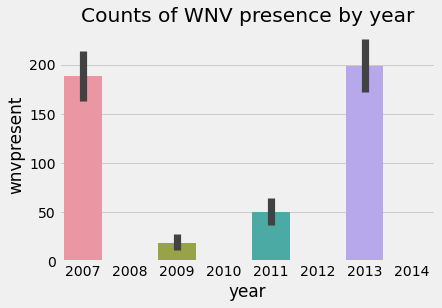

In [75]:
# Count of WNV present by year
sns.barplot(data=geo_traintest, x='year', y='wnvpresent', estimator=np.sum).set(
    title='Counts of WNV presence by year')

[Text(0.5, 1.0, 'Rate of WNV presence by year')]

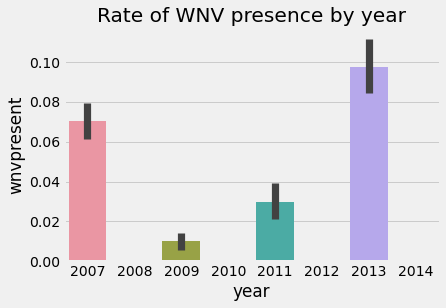

In [76]:
# Mean of WNV present by year (adjusting for the difference in number of readings taken)
sns.barplot(data=geo_traintest, x='year', y='wnvpresent', estimator=np.mean).set(
    title='Rate of WNV presence by year')

Text(0.5, 1.0, 'Count of WNV presence by trap')

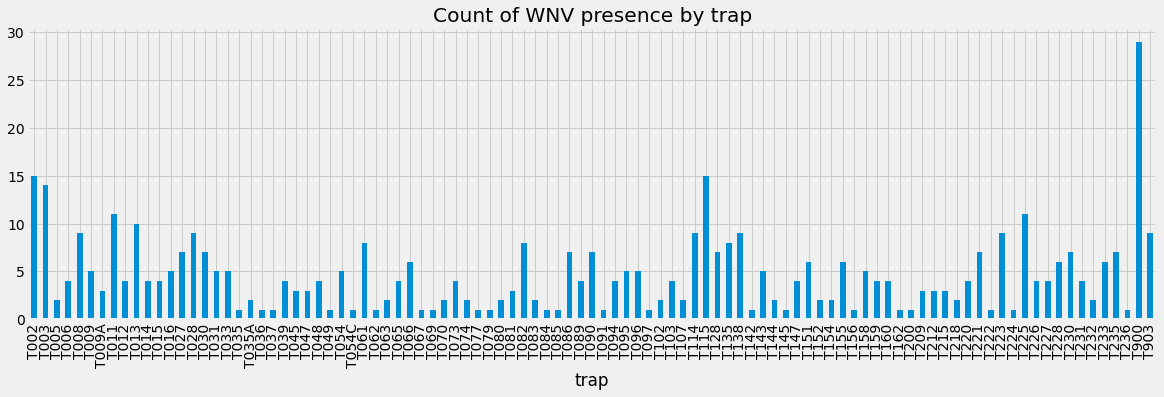

In [77]:
# Traps by number of WNV present readings
fig,ax = plt.subplots(figsize=(18,5))
geo_traintest.groupby('trap').sum()['wnvpresent'].loc[lambda x: x>0].plot.bar()
plt.title('Count of WNV presence by trap')

Text(0.5, 1.0, 'Rate of WNV presence by trap')

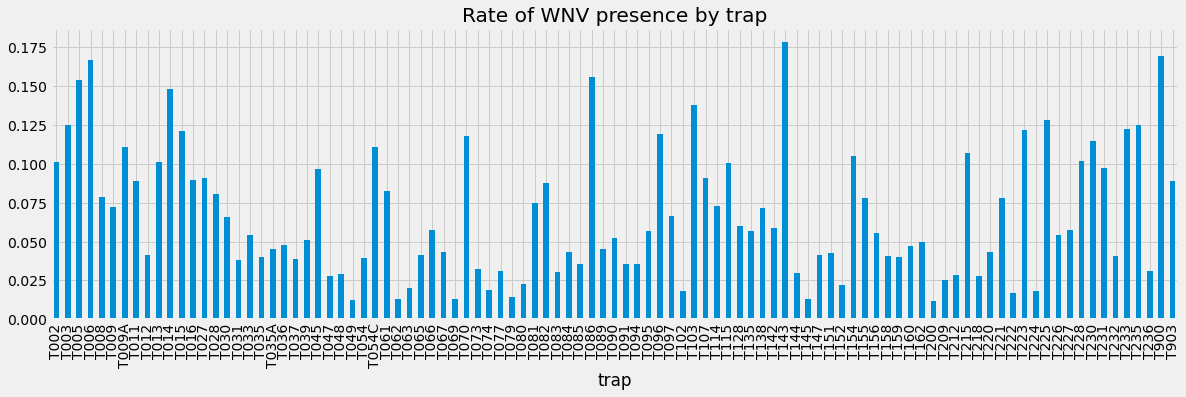

In [78]:
# Traps by number of WNV present readings
fig,ax = plt.subplots(figsize=(18,5))
geo_traintest.groupby('trap').mean()['wnvpresent'].loc[lambda x: x>0].plot.bar()
plt.title('Rate of WNV presence by trap')

In [79]:
# Filter traps that ever had WNV present
wnv_traps = geo_traintest.groupby('trap').sum()['wnvpresent'].loc[lambda x: x>0].index
wnv_filtered = geo_traintest[(geo_traintest['dataset']=='train') &
                (geo_traintest['trap'].isin(wnv_traps))]

In [80]:
# Pivot by year
pivot_by_year = pd.pivot_table(wnv_filtered,index=wnv_filtered['trap'],columns=wnv_filtered['date'].dt.year,
               values='wnvpresent',aggfunc=['count'])
pivot_by_year.isna().sum()
# Table: number of traps with WNV per year

       date
count  2007    18
       2009    33
       2011    27
       2013    31
dtype: int64

[Text(0.5, 1.0, 'Heatmap of mean WNV presence by trap by year')]

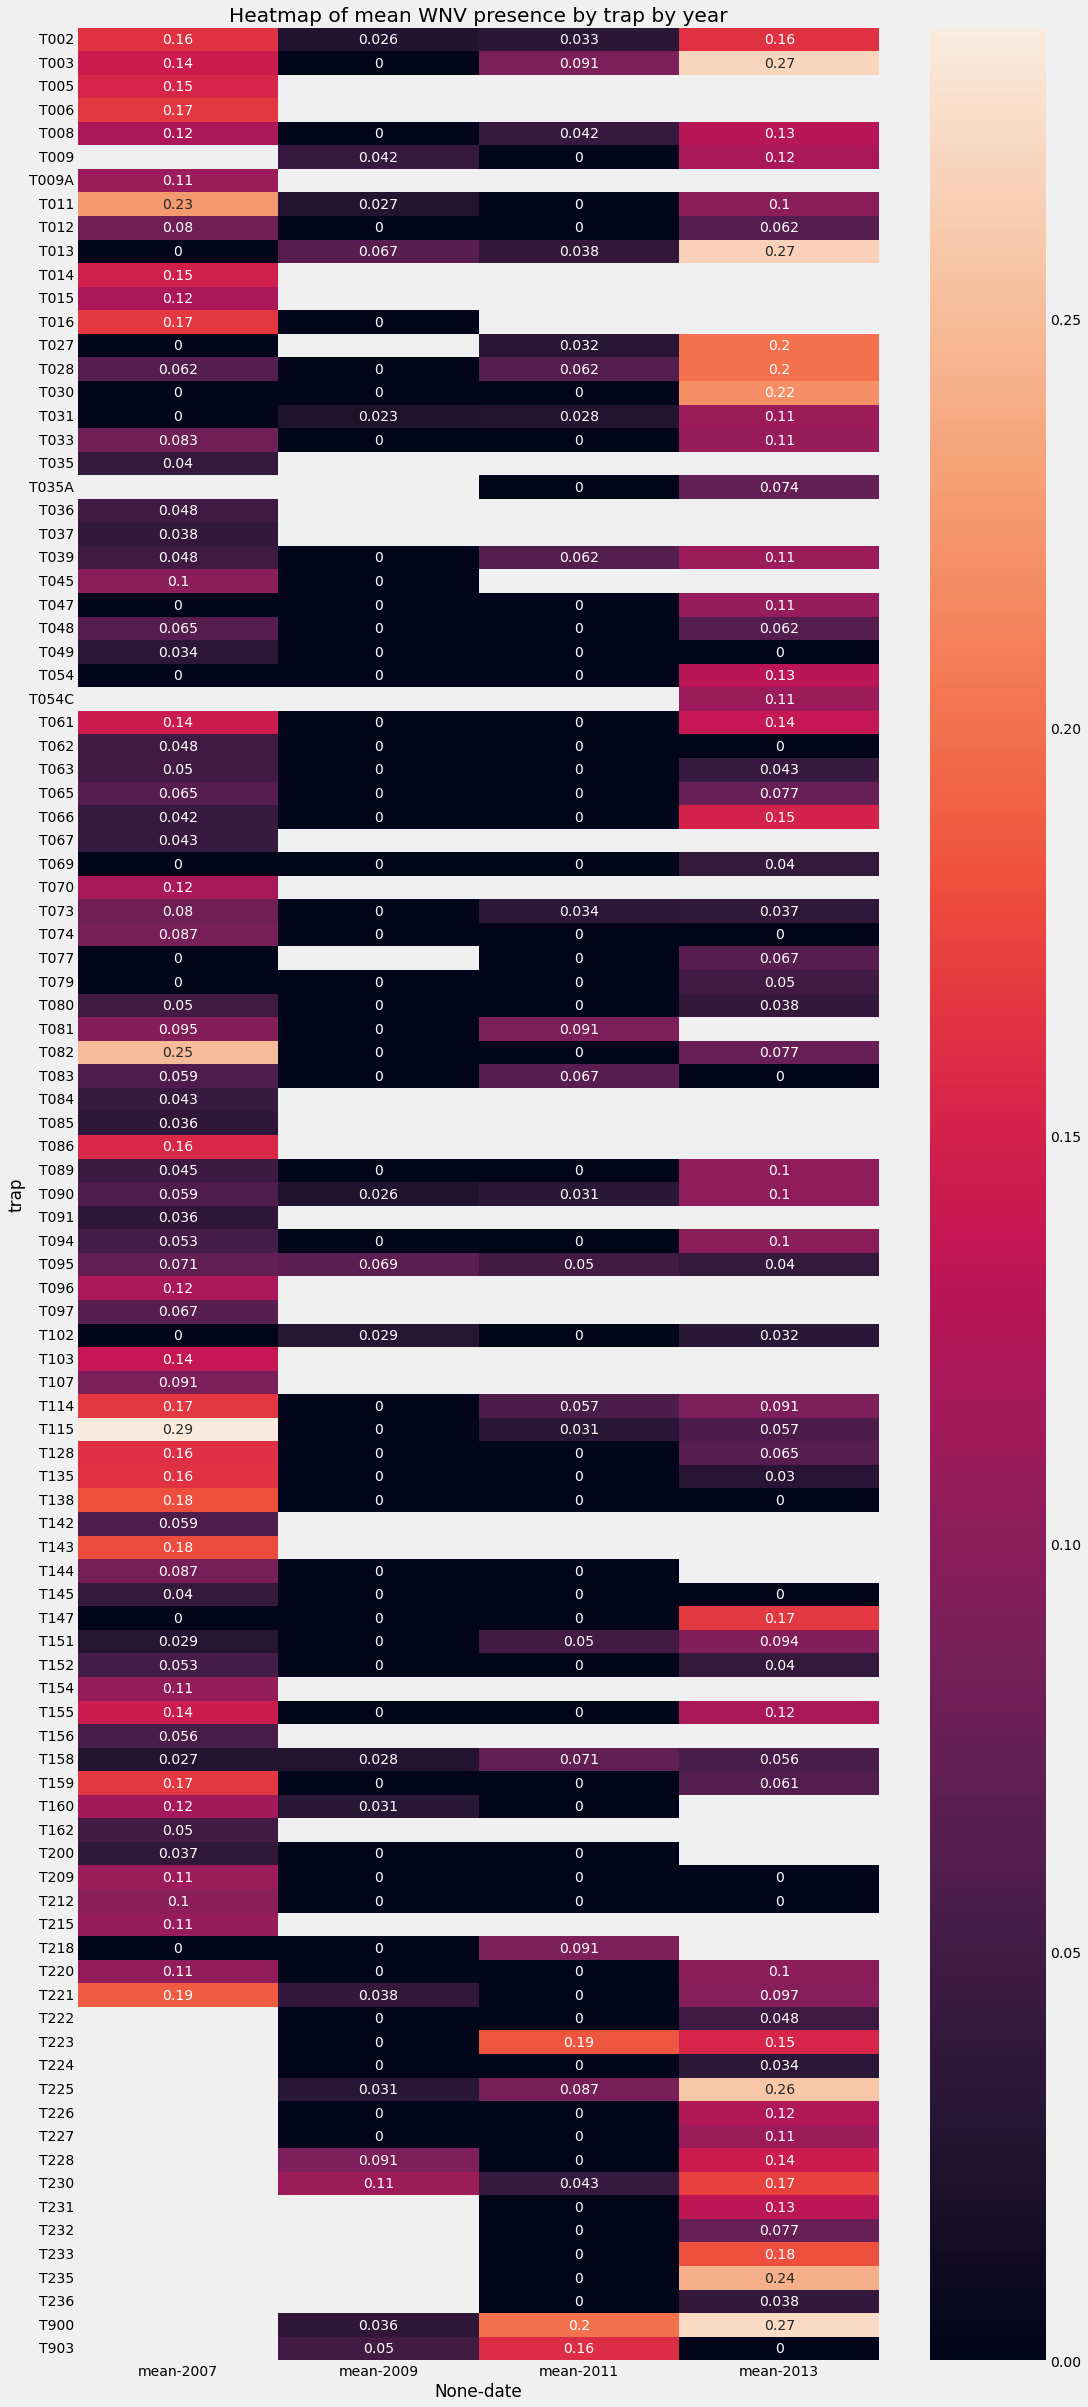

In [81]:
fig,ax = plt.subplots(figsize=(16,40))
sns.heatmap(pd.pivot_table(wnv_filtered,index=wnv_filtered['trap'],columns=wnv_filtered['date'].dt.year,
               values='wnvpresent',aggfunc=[np.mean]), annot=True)\
            .set(title= 'Heatmap of mean WNV presence by trap by year')

- Many traps that had high occurances of WNV in 2007 and/or 2013 had no occurance of WNV in 2009 and 2011. This suggests that weather could be a significant factor.

#### Date, Mosquito and WNVPresent

Text(0.5, 1.0, 'Relationship between Mosquito count and WNV presence')

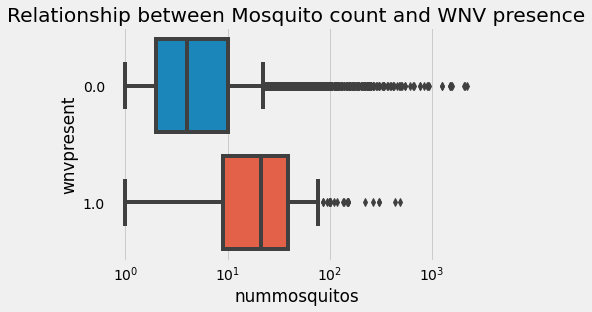

In [82]:
ax = fig
ax = sns.boxplot(data=geo_traintest, y='wnvpresent', x='nummosquitos', orient="h")
ax.set_xscale('log')
plt.title('Relationship between Mosquito count and WNV presence')

While there are many outliers for traps with absence of WNV, in general we can see that WNV presence is associated with high number of mosquitoes.

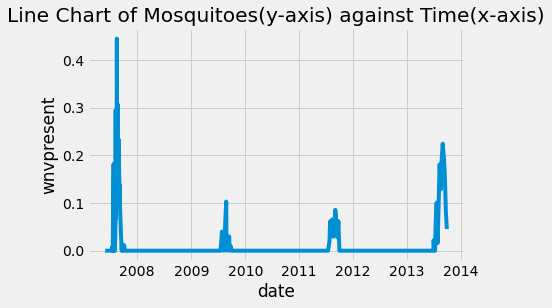

In [83]:
sns.lineplot(data=geo_traintest.groupby(['date']).mean()['wnvpresent']) \
                .set(title= 'Line Chart of Mosquitoes(y-axis) against Time(x-axis)');

#### to edit
- Number of mosquitoes typically surged around the mid of the year, as evident by the spikes in e.g. mid-2007, mid-2009.
- During this period, the occurrence of West Nile Virus also increased as evident by the spikes of black line in e.g. mid-2007, mid-2009
- In mid-2011 and mid-2013, the number of mosquitoes were fewer (i.e. less than 200). Corresponding, the occurrence of West Nile Virus was also fewer.
- Based on this, the number of mosquitoes and presence of West Nile Virus are likely to be strongly correlated.

In [84]:
# Calculate the rate of WNV by month and week, and year
wnv_by_year_month = pd.DataFrame(geo_traintest.groupby(['year','month'])
                                 .mean()['wnvpresent']).reset_index().dropna()

wnv_by_year_week = pd.DataFrame(geo_traintest.groupby(['year','week'])
                                 .mean()['wnvpresent']).reset_index().dropna()


[Text(0.5, 1.0, 'Line Chart of mean WNV rate by Week')]

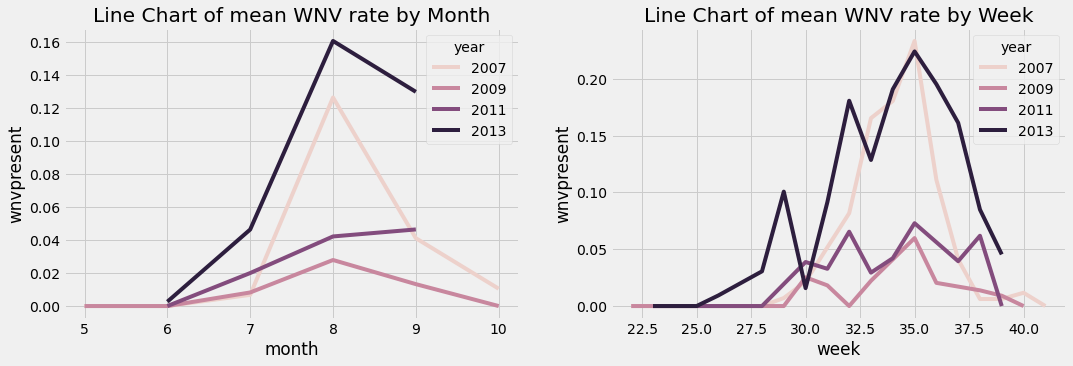

In [85]:
# Plot rate of WNV by month and week, and year
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
sns.lineplot(data=wnv_by_year_month, x='month', y='wnvpresent',hue='year') \
                .set(title= 'Line Chart of mean WNV rate by Month')

plt.subplot(1, 2, 2)
sns.lineplot(data=wnv_by_year_week, x='week', y='wnvpresent',hue='year') \
                .set(title= 'Line Chart of mean WNV rate by Week')

#### to edit
- The line graph for presence of West Nile Virus is consistently above the line for absence of West Nile Virus, further supporting that the number of mosquitoes and presence of West Nile Virus are likely to be strongly correlated
- Between Jun-Oct, the number of mosquitoes were the most between Jun-Aug. At locations without West Nile Virus, the number of mosquitoes increased since Jun and peaked in Aug while at locations with West Nile Virus, the number of mosquitoes declined slightly from Jun to Aug, suggesting that there could be some other features which affect the trajectory (e.g. spraying pesticide in these locations)

#### Trap and spray locations

In [87]:
geo_traintest['year']

0         2007
1         2007
2         2007
3         2007
4         2007
          ... 
126784    2014
126785    2014
126791    2014
126792    2014
126793    2014
Name: year, Length: 51339, dtype: int64

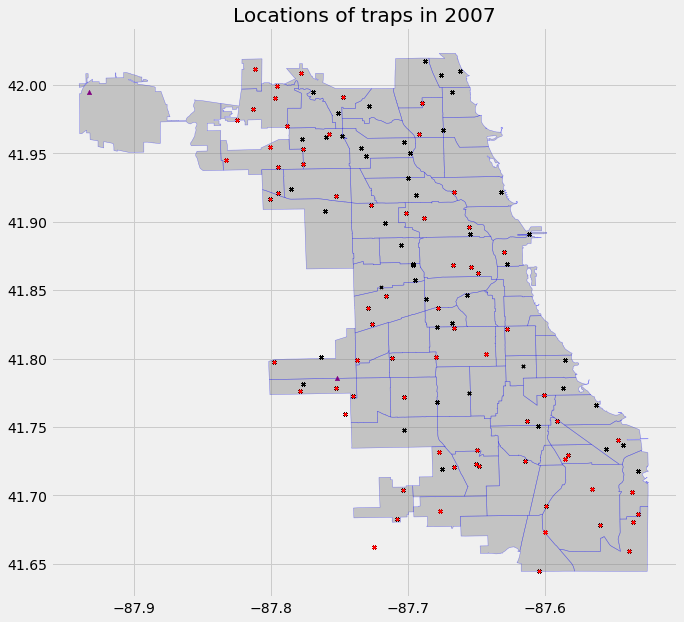

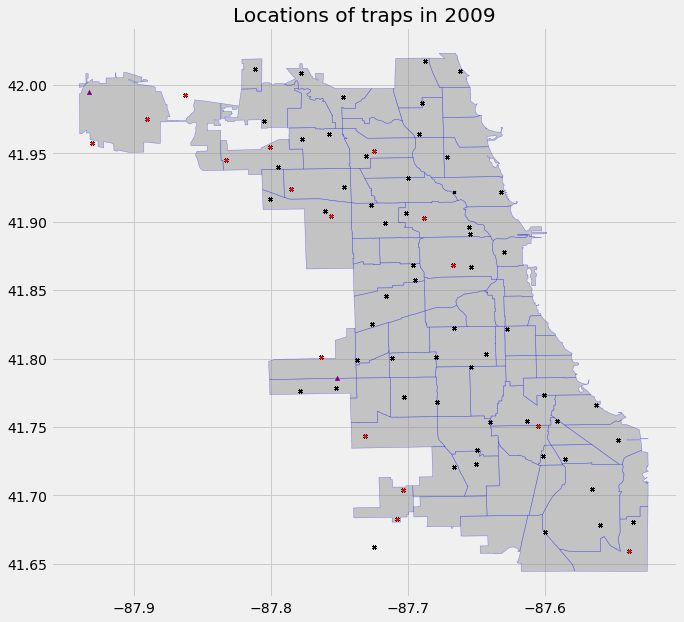

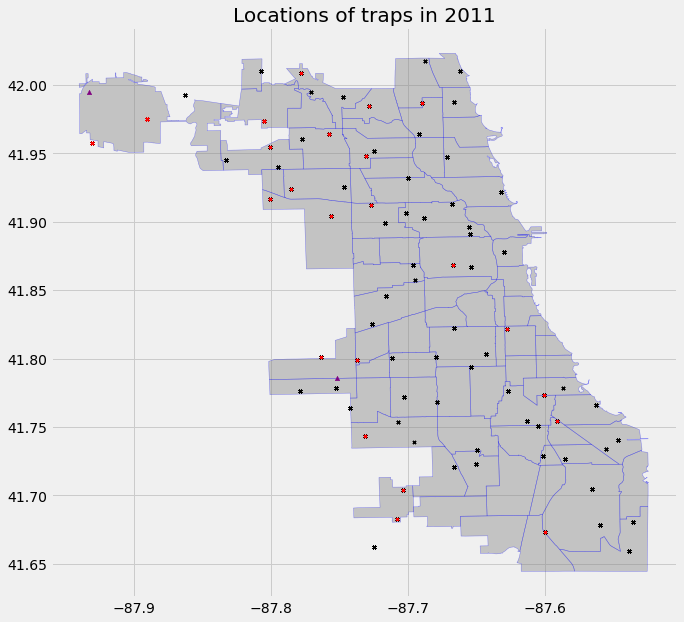

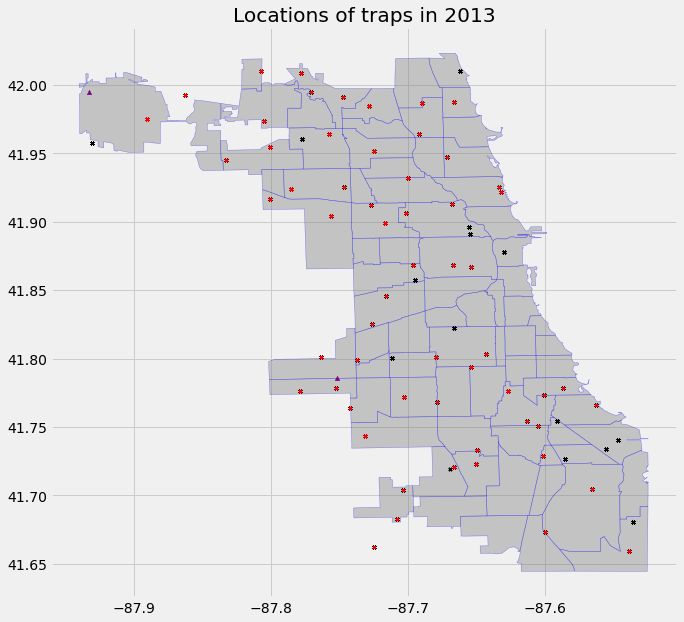

In [88]:
for year in [2007,2009,2011,2013]:
    fig,ax = plt.subplots(figsize=(10,10))
    community_map.plot(ax=ax, alpha=0.4, color='grey',vmin=0, vmax=10,
                      edgecolor='blue'
                     )
    geo_traintest.loc[(geo_traintest['wnvpresent']==0)& 
                      (geo_traintest['year']==year),
                      ['geometry']].plot(ax=ax, markersize=1, color='black', marker='x', label='trap')
    geo_traintest.loc[(geo_traintest['wnvpresent']==1)& 
                      (geo_traintest['year']==year),
                      ['geometry']].plot(ax=ax, markersize=1, color='red', marker='x', label='trap')
    geo_stations['geometry'].plot(ax=ax, markersize=20, color='purple', marker='^', label='station')
    plt.title((f'Locations of traps in {year}'))

- We hypothesized that traps that are closer together might have a higher chance of having similar status of having WNV or not.

- However it appears that the proximity between traps is not a significant factor of whether the virus is present or not given that there are a significant number of traps that are relatively close by but have differ on whether WNV was present.

Text(0.5, 1.0, 'Sprays conducted in 2013')

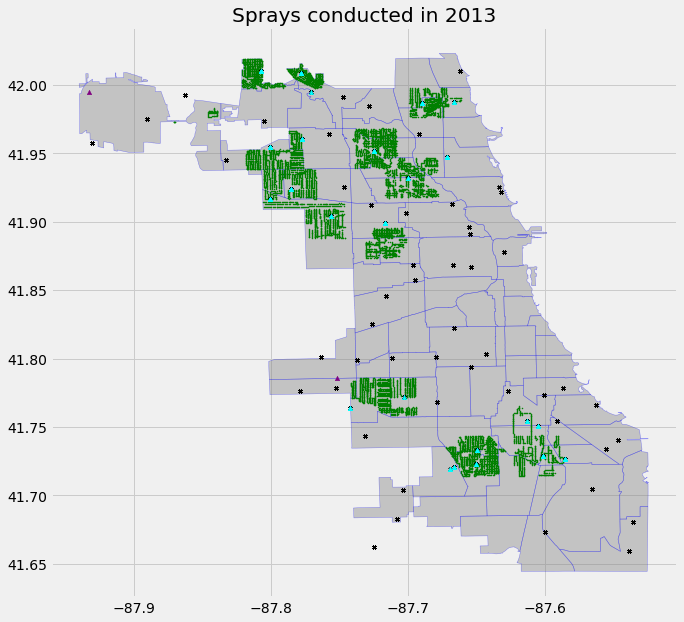

In [90]:
fig,ax = plt.subplots(figsize=(10,10))
community_map.plot(ax=ax, alpha=0.4, color='grey',vmin=0, vmax=10,
                      edgecolor='blue'
                     )

geo_spray[geo_spray['year']==2013].plot(ax=ax, markersize=1, color='green', marker='o', label='spray')
geo_traintest[geo_traintest['year']== 2013].plot(ax=ax, markersize=1, color='black', marker='x', label='trap')
geo_stations['geometry'].plot(ax=ax, markersize=20, color='purple', marker='^', label='station')

geo_traintest[(geo_traintest['year']== 2013) & 
              (geo_traintest['is_spray']==1)
             ]['geometry'].plot(ax=ax, markersize=20, color='cyan', marker='^', label='sprayed trap')
plt.title((f'Sprays conducted in 2013'))

In [162]:
# Select traps by date & is spray
spray_dict = geo_traintest[geo_traintest['date'].isin(spray_dates)&(geo_traintest['is_spray']==1)] \
    .groupby('date')['trap'].apply(set).to_dict()  
# display

In [169]:
spray_dict.keys()


dict_keys([Timestamp('2013-07-25 00:00:00'), Timestamp('2013-08-08 00:00:00'), Timestamp('2013-08-15 00:00:00'), Timestamp('2013-08-22 00:00:00'), Timestamp('2013-08-29 00:00:00')])

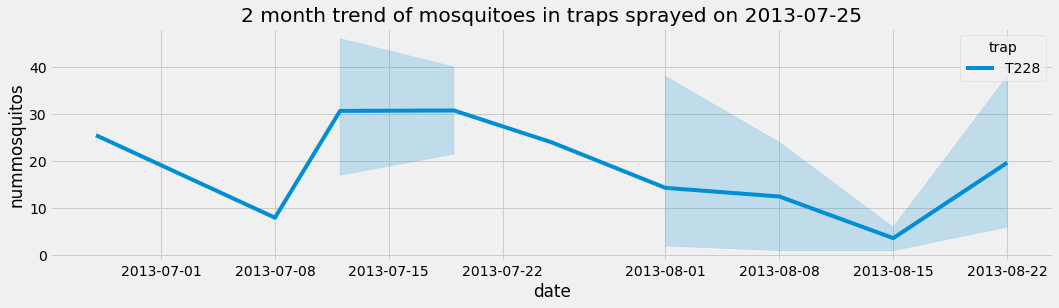

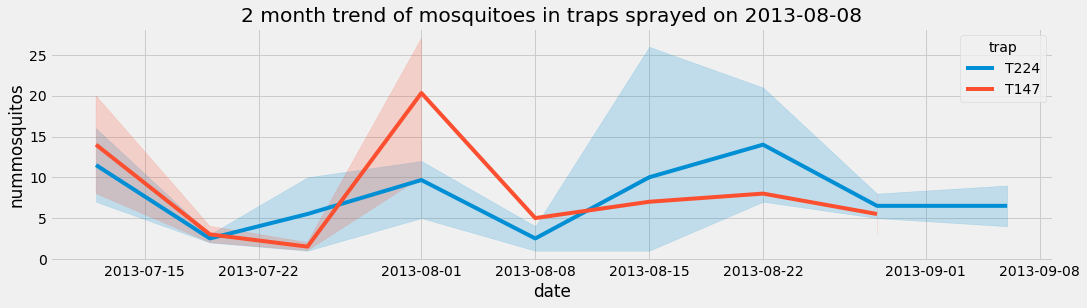

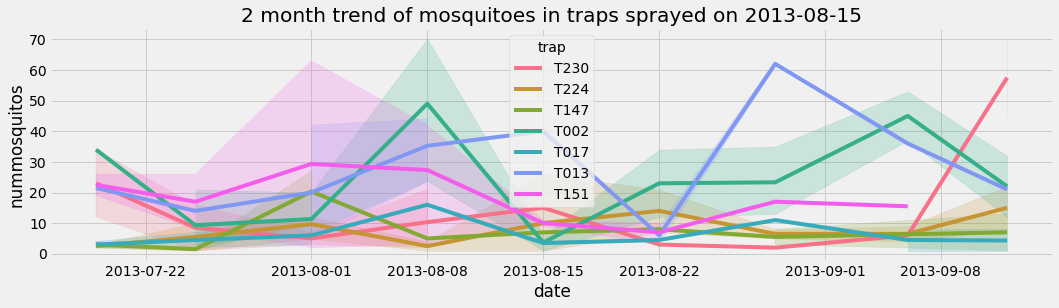

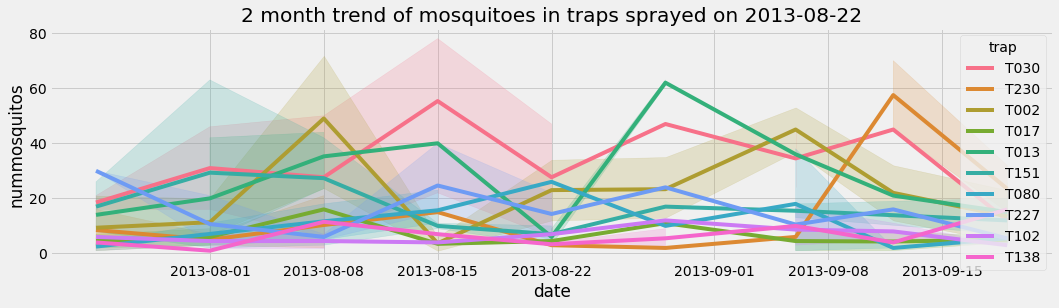

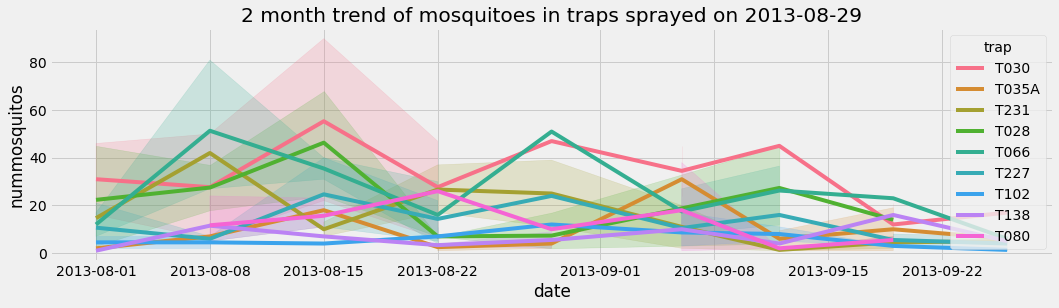

In [187]:
for key, values in spray_dict.items():
    spray_date = key.date()
    fig,ax = plt.subplots(figsize=(16,4))
    filtered = geo_traintest[(geo_traintest['trap'].isin(values)) &
                             (geo_traintest['date'].dt.date >= spray_date-timedelta(days=30)) &
                             (geo_traintest['date'].dt.date <= spray_date+timedelta(days=30))]
    sns.lineplot(data=filtered, x='date', y='nummosquitos', hue='trap')
    plt.title((f'2 month trend of mosquitoes in traps sprayed on {spray_date}'))

Text(0.5, 1.0, 'Sprays conducted in 2013 - check individual traps in red')

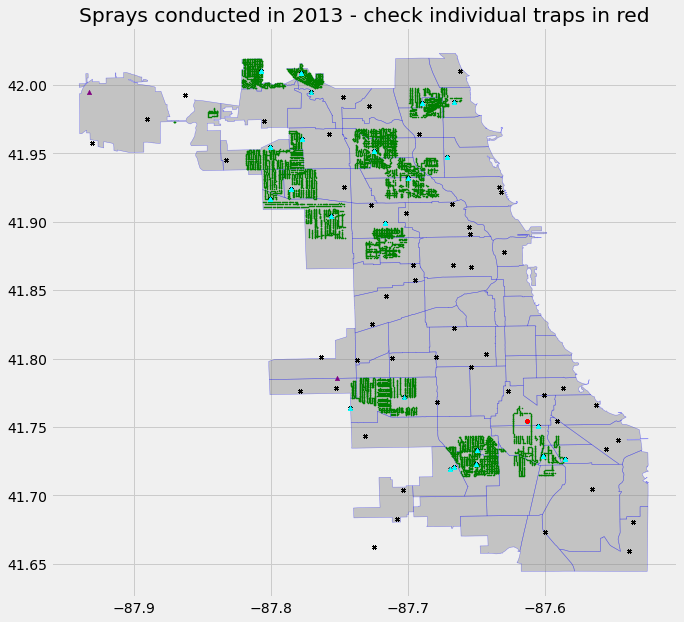

In [194]:
fig,ax = plt.subplots(figsize=(10,10))
community_map.plot(ax=ax, alpha=0.4, color='grey',vmin=0, vmax=10,
                      edgecolor='blue'
                     )

geo_spray[geo_spray['year']==2013].plot(ax=ax, markersize=1, color='green', marker='o', label='spray')
geo_traintest[geo_traintest['year']==2013].plot(ax=ax, markersize=1, color='black', marker='x', label='trap')
geo_stations['geometry'].plot(ax=ax, markersize=20, color='purple', marker='^', label='station')
geo_traintest[(geo_traintest['year']== 2013) & 
              (geo_traintest['is_spray']==1)
             ]['geometry'].plot(ax=ax, markersize=20, color='cyan', marker='^', label='sprayed trap')

# Check individual traps
geo_traintest[geo_traintest['trap']=='T080'].plot(ax=ax, markersize=2, color='red', marker='x', label='trap')

plt.title((f'Sprays conducted in 2013 - check individual traps in red'))